In [1]:
import os
# import drjit
gpu_num = 2 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sionna
import tensorflow as tf
import pickle
import jammer
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')

from jammer.simulation_model import *
from jammer.utils import *
import jammer.simulation_model as sim
from tensorflow.python.keras.losses import MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy

In [2]:
sim.EBN0_DB_MIN = -10
sim.EBN0_DB_MAX = 15
# sim.NUM_SNR_POINTS = 10
# sim.BATCH_SIZE = 12
# sim.MAX_MC_ITER = 15
sim.NUM_SNR_POINTS = 26
sim.BATCH_SIZE = 512
sim.MAX_MC_ITER = 1500
sim.ebno_dbs = np.linspace(sim.EBN0_DB_MIN, sim.EBN0_DB_MAX, sim.NUM_SNR_POINTS)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 1.6531e-01 | 1.0000e+00 |      346686 |     2097152 |          512 |         512 |        11.1 |reached max iter       
   -7.222 | 7.4796e-02 | 1.0000e+00 |      156859 |     2097152 |          512 |         512 |         0.6 |reached max iter       
   -4.444 | 2.1282e-02 | 1.0000e+00 |       44632 |     2097152 |          512 |         512 |         0.5 |reached max iter       
   -1.667 | 3.1271e-03 | 9.9219e-01 |        6558 |     2097152 |          508 |         512 |         0.5 |reached max iter       
    1.111 | 2.6751e-04 | 3.7891e-01 |         561 |     2097152 |          194 |         512 |         0.6 |reached max iter       
    3.889 | 1.7166e-05 | 4.6875e-02 |          36 |     2097152 |           24 |     

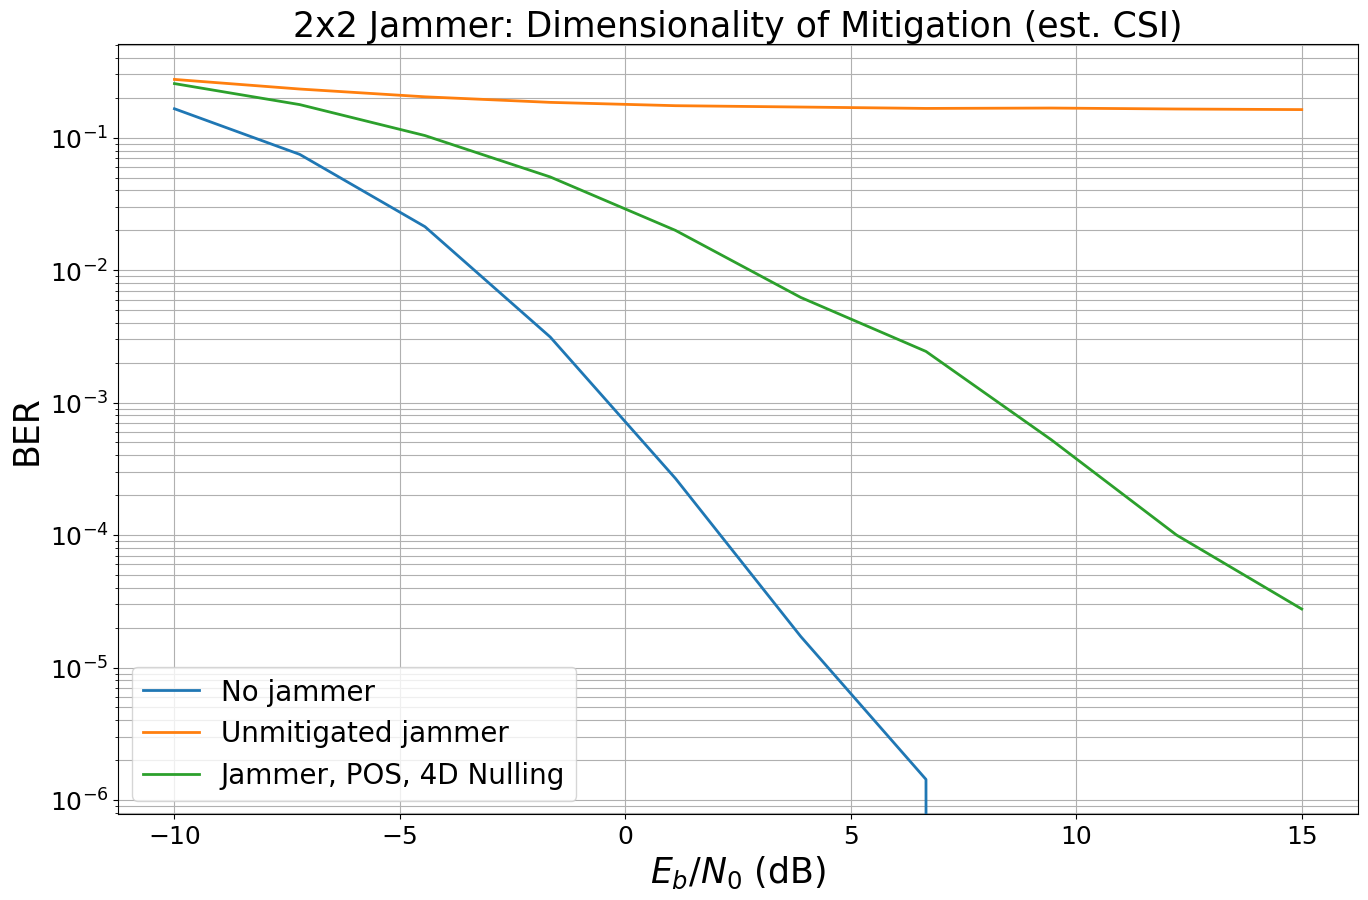

In [3]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters

model_parameters["num_silent_pilot_symbols"] = 6
jammer_parameters["num_tx"] = 2
jammer_parameters["num_tx_ant"] = 2

model = Model(**model_parameters)
simulate_model(model, f"No jammer")

model_parameters["jammer_present"] = True
model = Model(**model_parameters)
simulate_model(model, f"Unmitigated jammer")

d = 4
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = d
model = Model(**model_parameters)
simulate_model(model, f"Jammer, POS, {d}D Nulling")
    
ber_plots.title = "2x2 Jammer: Dimensionality of Mitigation (est. CSI)"
ber_plots()
with open("bers/paper/frequency/mitigation_dim.pickle", "wb") as f:
    pickle.dump(ber_plots, f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 2.5776e-01 | 1.0000e+00 |      405422 |     1572864 |          512 |         512 |         5.6 |reached max iter       
   -7.222 | 1.1776e-02 | 1.6797e-01 |       18522 |     1572864 |           86 |         512 |         0.6 |reached max iter       
   -4.444 | 3.1217e-04 | 3.9062e-03 |         491 |     1572864 |            2 |         512 |         0.6 |reached max iter       
   -1.667 | 0.0000e+00 | 0.0000e+00 |           0 |     1572864 |            0 |         512 |         0.6 |reached max iter       

Simulation stopped as no error occurred @ EbNo = -1.7 dB.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
--------------------------------------

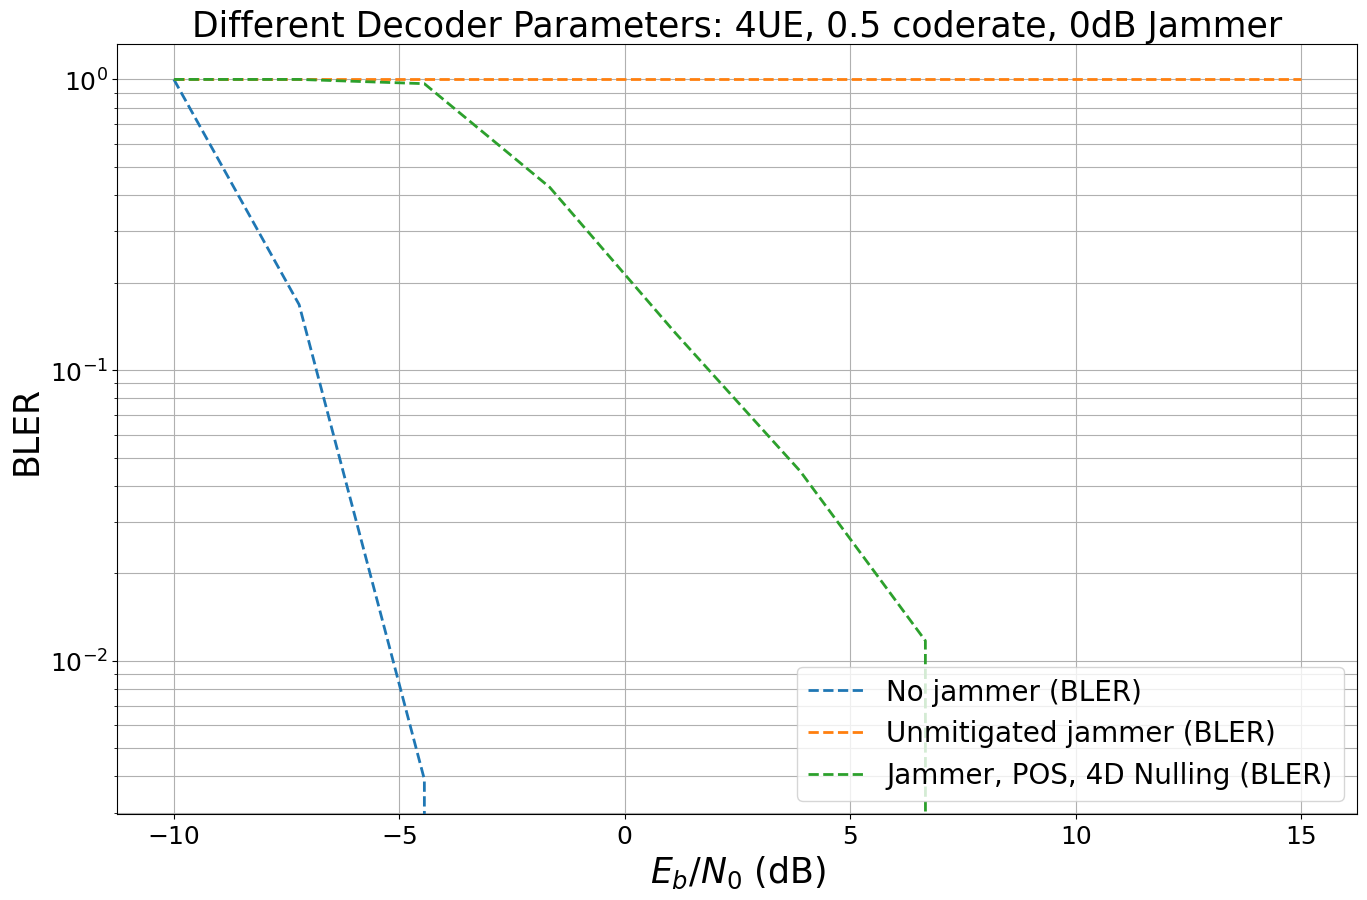

In [4]:
# TODO change iterations
# sim.MAX_MC_ITER = 3000
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
decoder_parameters={}
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["decoder_parameters"] = decoder_parameters

model_parameters["num_silent_pilot_symbols"] = 4
jammer_parameters["num_tx"] = 2
jammer_parameters["num_tx_ant"] = 2
model_parameters["coderate"] = 0.5
decoder_parameters["cn_type"] = "minsum"
decoder_parameters["num_iter"] = 20

model = Model(**model_parameters)
model._decoder.llr_max = 1000
simulate_model(model, f"No jammer", add_bler=True)

model_parameters["jammer_present"] = True
model = Model(**model_parameters)
model._decoder.llr_max = 1000
simulate_model(model, "Unmitigated jammer", add_bler=True)

d = 4
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = d
model = Model(**model_parameters)
simulate_model(model, f"Jammer, POS, {d}D Nulling", add_bler=True)

ber_plots.title = "Different Decoder Parameters: 4UE, 0.5 coderate, 0dB Jammer"
ber_plots(show_ber=False)
with open("bers/paper/frequency/mitigation_bler.pickle", "wb") as f:
    pickle.dump(ber_plots, f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 3.0320e-01 | 1.0000e+00 |      953778 |     3145728 |          512 |         512 |        10.1 |reached max iter       
   -7.222 | 2.4635e-01 | 1.0000e+00 |      774941 |     3145728 |          512 |         512 |         0.5 |reached max iter       
   -4.444 | 1.9878e-01 | 1.0000e+00 |      625311 |     3145728 |          512 |         512 |         0.5 |reached max iter       
   -1.667 | 1.6943e-01 | 1.0000e+00 |      532972 |     3145728 |          512 |         512 |         0.5 |reached max iter       
    1.111 | 1.5017e-01 | 1.0000e+00 |      472382 |     3145728 |          512 |         512 |         0.5 |reached max iter       
    3.889 | 1.4207e-01 | 1.0000e+00 |      446909 |     3145728 |          512 |     

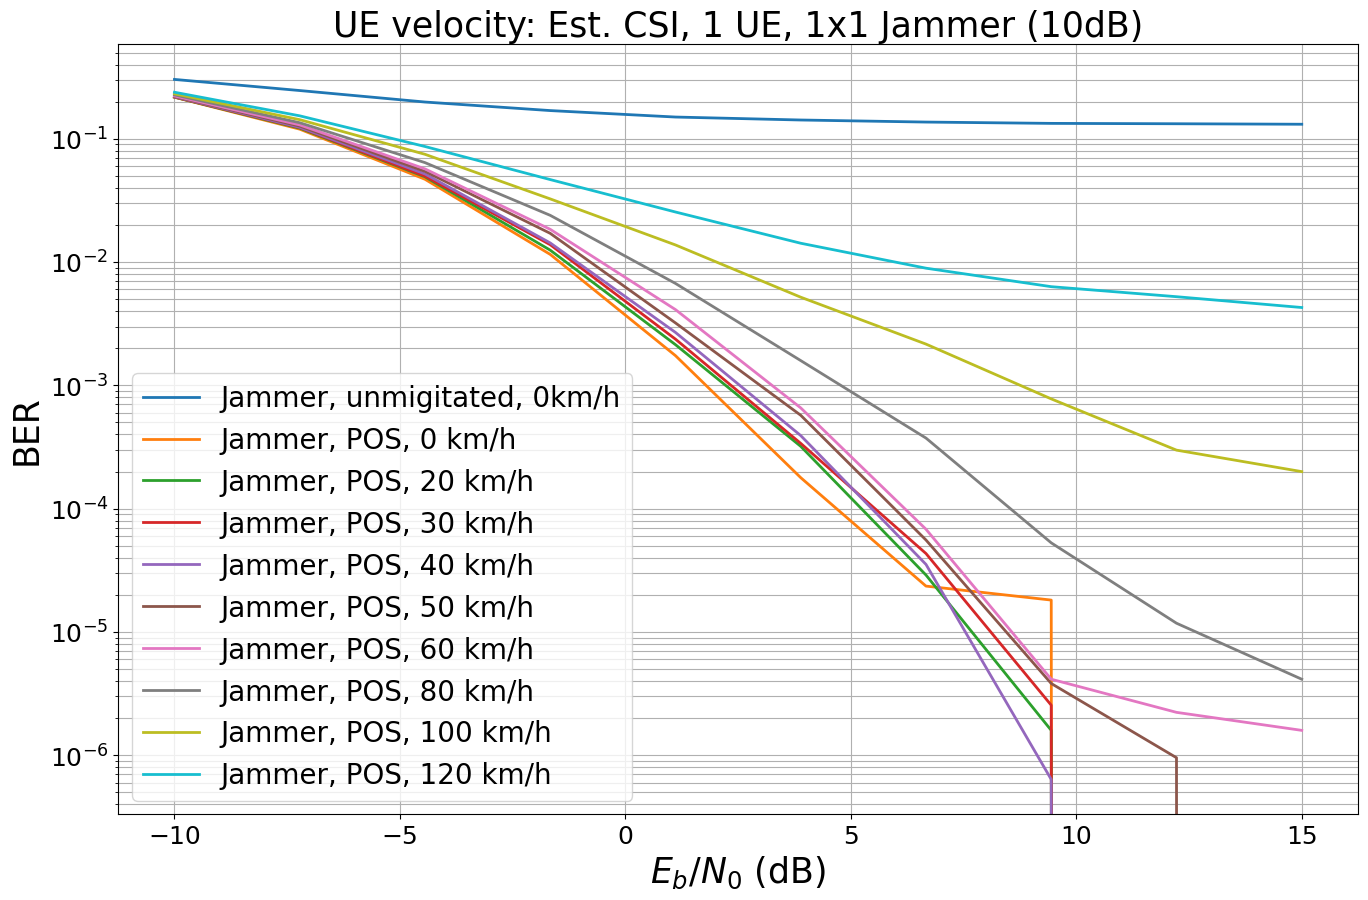

In [5]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters

model_parameters["num_silent_pilot_symbols"] = 4
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(10.)

model = Model(**model_parameters)
simulate_model(model, "Jammer, unmigitated, 0km/h")

model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 1
kmhs = [0, 20, 30, 40, 50, 60, 80, 100, 120]
for kmh in kmhs:
    meter_per_second = kmh / 3.6
    model_parameters["min_ut_velocity"] = meter_per_second
    model_parameters["max_ut_velocity"] = meter_per_second
    # model_parameters["min_jammer_velocity"] = meter_per_second
    # model_parameters["max_jammer_velocity"] = meter_per_second
    model = Model(**model_parameters)
    simulate_model(model, f"Jammer, POS, {kmh} km/h")

ber_plots.title = "UE velocity: Est. CSI, 1 UE, 1x1 Jammer (10dB)"
ber_plots()
with open("bers/paper/frequency/ut_velocity_mitigation.pickle", "wb") as f:
    pickle.dump(ber_plots, f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 3.0227e-01 | 1.0000e+00 |      950859 |     3145728 |          512 |         512 |        10.0 |reached max iter       
   -7.222 | 2.4673e-01 | 1.0000e+00 |      776140 |     3145728 |          512 |         512 |         0.5 |reached max iter       
   -4.444 | 1.9921e-01 | 1.0000e+00 |      626645 |     3145728 |          512 |         512 |         0.5 |reached max iter       
   -1.667 | 1.6924e-01 | 1.0000e+00 |      532377 |     3145728 |          512 |         512 |         0.5 |reached max iter       
    1.111 | 1.5104e-01 | 1.0000e+00 |      475139 |     3145728 |          512 |         512 |         0.5 |reached max iter       
    3.889 | 1.4151e-01 | 1.0000e+00 |      445160 |     3145728 |          512 |     

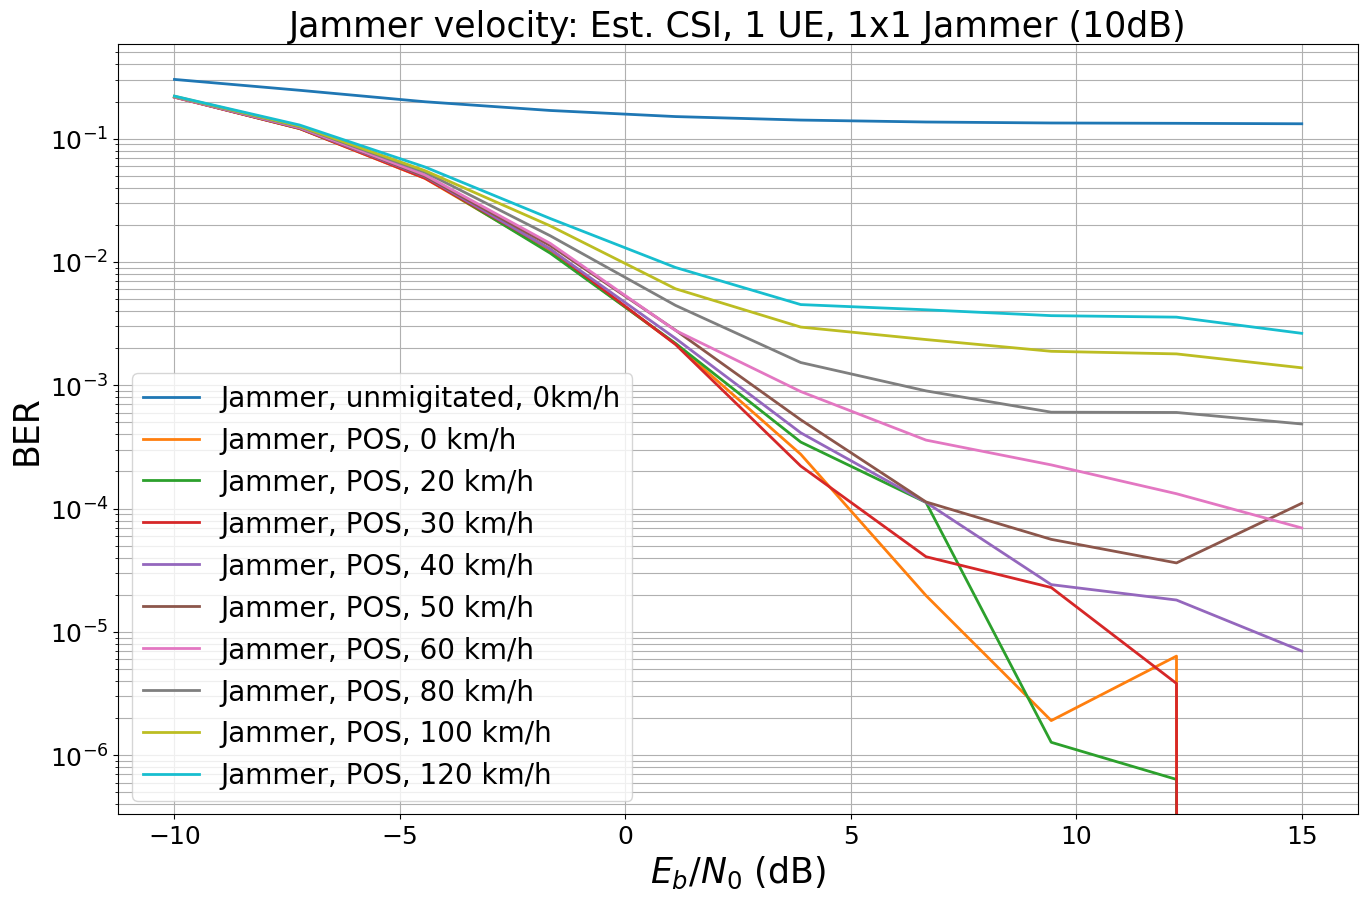

In [6]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters

model_parameters["num_silent_pilot_symbols"] = 4
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(10.)

model = Model(**model_parameters)
simulate_model(model, "Jammer, unmigitated, 0km/h")

model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 1
kmhs = [0, 20, 30, 40, 50, 60, 80, 100, 120]
for kmh in kmhs:
    meter_per_second = kmh / 3.6
    # model_parameters["min_ut_velocity"] = meter_per_second
    # model_parameters["max_ut_velocity"] = meter_per_second
    model_parameters["min_jammer_velocity"] = meter_per_second
    model_parameters["max_jammer_velocity"] = meter_per_second
    model = Model(**model_parameters)
    simulate_model(model, f"Jammer, POS, {kmh} km/h")

ber_plots.title = "Jammer velocity: Est. CSI, 1 UE, 1x1 Jammer (10dB)"
ber_plots()
with open("bers/paper/frequency/jammer_velocity_mitigation.pickle", "wb") as f:
    pickle.dump(ber_plots, f)